### CITS4404 Practical Project

# Camo Worms!

<div style="margin-left: 0px">
    &nbsp;
    <img src="velvet-worms.jpg" width=600>
    <br>
    <br>
</div>

Australian _velvet worms_ come in many colours, possibly as a camouflage function ([Current Biology](https://www.cell.com/current-biology/comments/S0960-9822(11)00208-9)).

In [61]:
# Imports

import numpy as np
import imageio.v3 as iio

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import matplotlib.bezier as mbezier
from sklearn.metrics.pairwise import euclidean_distances

rng = np.random.default_rng()
Path = mpath.Path
mpl.rcParams['figure.dpi']= 72 #size of images


In [62]:
# Global variables

IMAGE_DIR = 'images'
IMAGE_NAME='original'
MASK = [320, 560, 160, 880] # ymin ymax xmin xmax    # THIS ONE WAS BREAKING colour at t

Image name (shape) (intensity max, min, mean, std)

original (240, 720) (210, 0, 49.3, 34.8)


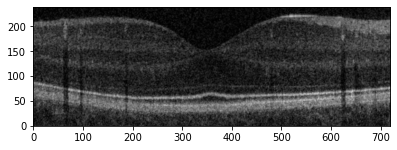

In [63]:
# Read, crop and display image and stats

def crop (image, mask):
    h, w = np.shape(image)
    return image[max(mask[0],0):min(mask[1],h), max(mask[2],0):min(mask[3],w)]

def prep_image (imdir, imname, mask):
    print("Image name (shape) (intensity max, min, mean, std)\n")
    image = np.flipud(crop(iio.imread(imdir+'/'+imname+".png"), mask))
    print("{} {} ({}, {}, {}, {})".format(imname, np.shape(image), np.max(image), np.min(image), round(np.mean(image),1), round(np.std(image),1)))
    plt.imshow(image, vmin=0, vmax=255, cmap='gray', origin='lower') # use vmin and vmax to stop imshow from scaling
    plt.show()
    return image

image = prep_image(IMAGE_DIR, IMAGE_NAME, MASK)

In [64]:
class Camo_Worm:
    def __init__(self, x, y, r, theta, deviation_r, deviation_gamma, width, colour):
        self.x = x
        self.y = y
        self.r = r
        self.theta = theta
        self.dr = deviation_r
        self.dgamma = deviation_gamma
        self.width = width
        self.colour = colour
        p0 = [self.x - self.r * np.cos(self.theta), self.y - self.r * np.sin(self.theta)]
        p2 = [self.x + self.r * np.cos(self.theta), self.y + self.r * np.sin(self.theta)]
        p1 = [self.x + self.dr * np.cos(self.theta+self.dgamma), self.y + self.dr * np.sin(self.theta+self.dgamma)]
        self.bezier = mbezier.BezierSegment(np.array([p0, p1,p2]))

    def control_points (self):
        return self.bezier.control_points

    def path (self):
        return mpath.Path(self.control_points(), [Path.MOVETO, Path.CURVE3, Path.CURVE3])

    def patch (self):
        return mpatches.PathPatch(self.path(), fc='None', ec=str(self.colour), lw=self.width, capstyle='round')
    
    def edge_points (self, intervals, print_results=False):
        """
        Genenerates edge points around a worm, based on width
        """
        edge_points = []

        # Get Parallels returns two parallel lines separated by a width. 
        # This is not quite the true edge points as the end caps will be incorrect
        edge_points = np.array(
            mbezier.get_parallels(self.control_points(), self.width)
        )

        # The points returned are control points, not intermediate points.
        line1 = mbezier.BezierSegment(edge_points[0])
        line2 = mbezier.BezierSegment(edge_points[1])

        # Borrowed from the intermediate_points() method
        line1points = line1.point_at_t(np.linspace(0,1,intervals))
        line2points = line2.point_at_t(np.linspace(0,1,intervals))

        # Merge the two parallel lines into one continuous set of points:
        merged = np.concatenate((line1points, line2points), axis=0)

        if(print_results):
            print("control points: \n{}".format(self.control_points()))
            print("Edge Points: \n{}".format(merged))

        return merged

    def intermediate_points (self, intervals=None):
        if intervals is None:
            intervals = max(3, int(np.ceil(self.r/8)))
        return self.bezier.point_at_t(np.linspace(0,1,intervals))

    def approx_length (self):
        intermediates = self.intermediate_points()
        eds = euclidean_distances(intermediates,intermediates)
        return np.sum(np.diag(eds,1))
    
    def coords_at_t(self, t):
        intermediates = np.int64(np.round(np.array(self.bezier.point_at_t(t)).reshape(-1,2)))[0]
        return intermediates

    def colour_at_t(self, t, image):
        """
        intermediates = np.int64(np.round(np.array(self.bezier.point_at_t(t)).reshape(-1,2)))
        colours = [image[point[0],point[1]] for point in intermediates]
        """
        point = np.int64(np.round(np.array(self.bezier.point_at_t(t)).reshape(-1,2)))[0]

        """
        # ignore points outside image
        xmin, xmax = [0, image.shape[0]]
        ymin, ymax = [0, image.shape[1]]
        if(    point[1] > xmin 
           and point[1] < xmax
           and point[0] > ymin
           and point[0] < ymax ):
            colours = image[point[1],point[0]] # reversed as [y, x]
            colour = np.array(colours)/255
            return colour
        else:
            return -1
        """
        # Coordinates are flipped in the next function
        x = point[0]
        y = point[1]

        return self.colour_at_xy(x, y, image)


    def colour_at_xy(self, x, y, image):

        #print("Colours at point: (x,y) = ({},{})".format(x, y))

        # ignore points outside image
        xmin, xmax = [0, image.shape[0]]
        ymin, ymax = [0, image.shape[1]]
        # Confusingly, point coordinates follow [x,y], while pixel matrix coords follow [y,x]
        if(    y > xmin 
           and y < xmax
           and x > ymin
           and x < ymax ):
            #print("xmin={} < y={} < xmax={}".format(xmin, y, xmax))
            #print("ymin={} < x={} < ymax={}".format(ymin, x, ymax))
            colours = image[y,x] # reversed as [y, x]
            #print("Colour = {}".format(colours))
            colour = np.array(colours)/255
            return colour
        else:
            return -1
    



    def print_variables(self):
        #print("[x,y,r,theta,dr,dgamma,width,colour]")
        print("[{x},{y},{r},{theta},{dr},{dgamma},{width},{colour}]".format(
            x = round(self.x, 2), 
            y= round(self.y, 2),
            r= round(self.r, 2),
            theta= round(self.theta, 2),
            dr= round(self.dr, 2),
            dgamma= round(self.dgamma, 2),
            width= round(self.width, 2),
            colour= round(self.colour, 2)
            )
        )
    
    def mate(self, partner):
        
        
        # 45% chance to pick one parent
        # 45% chance to pick other
        # 10% chance to mutate

        (radius_std, deviation_std, width_theta) = (40, 30, 1)
        (ylim, xlim) = image.shape
        
        #centerpoint coord x
        rand = rng.random() # 0 to 1
        if(rand < 0.45):       ch_x = self.x
        elif(rand < 0.9):      ch_x = partner.x
        else:                  ch_x = xlim * rng.random()
        #else:                  ch_x = (self.x + partner.x)/2

        #centerpoint coord y
        rand = rng.random()
        if(rand < 0.45):       ch_y = self.y
        elif(rand < 0.9):      ch_y = partner.y
        else:                  ch_y = ylim * rng.random()
        #else:                  ch_y = (self.y + partner.y)/2

        #radius
        rand = rng.random()       
        if(rand < 0.45):       ch_r = self.r
        elif(rand < 0.9):      ch_r = partner.r
        else:                  ch_r = radius_std * np.abs(rng.standard_normal())
        #else:                  ch_r = (self.r + partner.r)/2

        #angle from x axis
        rand = rng.random()        
        if(rand < 0.45):       ch_theta = self.theta
        elif(rand < 0.9):      ch_theta = partner.theta
        else:                  ch_theta = rng.random() * np.pi
        #else:                  ch_theta = (self.theta + partner.theta)/2

        # radius of deviation from midpoint
        rand = rng.random()        
        if(rand < 0.45):       ch_dr = self.dr
        elif(rand < 0.9):      ch_dr = partner.dr
        else:                  ch_dr = deviation_std * np.abs(rng.standard_normal())
        #else:                  ch_dr = (self.dr + partner.dr)/2

        #angle of line joining midpoint and curve
        rand = rng.random()        
        if(rand < 0.45):       ch_dgamma = self.dgamma
        elif(rand < 0.9):      ch_dgamma = partner.dgamma
        else:                  ch_dgamma = rng.random() * np.pi
        #else:                  ch_dgamma = (self.dgamma + partner.dgamma)/2

        #thickness
        rand = rng.random()        
        if(rand < 0.45):       ch_width = self.width
        elif(rand < 0.9):      ch_width = partner.width
        else:                  ch_width = width_theta * rng.standard_gamma(3)
        #else:                  ch_width = (self.width + partner.width)/2

        # worm colour - 0 to 255
        rand = rng.random()
        if(rand < 0.45):       ch_colour = self.colour
        elif(rand < 0.9):      ch_colour = partner.colour
        else:                  ch_colour = rng.random()
        #else:                  ch_colour = (self.colour + partner.colour)/2
        
        child = Camo_Worm(
            ch_x,
            ch_y,
            ch_r,
            ch_theta,
            ch_dr,
            ch_dgamma,
            ch_width,
            ch_colour
        )
        
        """
        print("Self:")
        self.print_variables()
        print("Partner:")
        partner.print_variables()
        print("Child:")
        child.print_variables()
        """
        
        return child


In [65]:
class Drawing:
    def __init__ (self, image):
        self.fig, (self.ax1, self.ax2) = plt.subplots(2)
        self.image = image
        self.im1 = self.ax1.imshow(self.image, cmap='gray', origin='lower')
        self.im2 = self.ax2.imshow(self.image, cmap='gray', vmin=255, vmax=255, origin='lower') # White background

    def add_patches1(self, patches):
        try:
            for patch in patches:
                self.ax1.add_patch(patch)
        except TypeError:
            self.ax1.add_patch(patches)

    def add_patches2(self, patches):
        try:
            for patch in patches:
                self.ax2.add_patch(patch)
        except TypeError:
            self.ax2.add_patch(patches)

    def add_dots(self, points, radius=4, **kwargs):
        try:
            for point in points:
                self.ax1.add_patch(mpatches.Circle((point[0],point[1]), radius, **kwargs))
                self.ax2.add_patch(mpatches.Circle((point[0],point[1]), radius, **kwargs))
        except TypeError:
            self.ax1.add_patch(mpatches.Circle((points[0],points[1]), radius, **kwargs))
            self.ax2.add_patch(mpatches.Circle((points[0],points[1]), radius, **kwargs))

    def add_worms(self, worms):
        try:
            self.add_patches1([w.patch() for w in worms])
            self.add_patches2([w.patch() for w in worms])
        except TypeError:
            self.add_patches1([worms.patch()])
            self.add_patches2([worms.patch()])

    def show(self, save=None):
        if save is not None:
            plt.savefig(save)

        plt.show()






""" class Drawing:
    def __init__ (self, image):
        self.fig, self.ax = plt.subplots()
        self.image = image
        self.im = self.ax.imshow(self.image, cmap='gray', origin='lower')

    def add_patches(self, patches):
        try:
            for patch in patches:
                self.ax.add_patch(patch)
        except TypeError:
            self.ax.add_patch(patches)

    def add_dots(self, points, radius=4, **kwargs):
        try:
            for point in points:
                self.ax.add_patch(mpatches.Circle((point[0],point[1]), radius, **kwargs))
        except TypeError:
            self.ax.add_patch(mpatches.Circle((points[0],points[1]), radius, **kwargs))

    def add_worms(self, worms):
        try:
            self.add_patches([w.patch() for w in worms])
        except TypeError:
            self.add_patches([worms.patch()])

    def show(self, save=None):
        if save is not None:
            plt.savefig(save)
        plt.show() """

" class Drawing:\n    def __init__ (self, image):\n        self.fig, self.ax = plt.subplots()\n        self.image = image\n        self.im = self.ax.imshow(self.image, cmap='gray', origin='lower')\n\n    def add_patches(self, patches):\n        try:\n            for patch in patches:\n                self.ax.add_patch(patch)\n        except TypeError:\n            self.ax.add_patch(patches)\n\n    def add_dots(self, points, radius=4, **kwargs):\n        try:\n            for point in points:\n                self.ax.add_patch(mpatches.Circle((point[0],point[1]), radius, **kwargs))\n        except TypeError:\n            self.ax.add_patch(mpatches.Circle((points[0],points[1]), radius, **kwargs))\n\n    def add_worms(self, worms):\n        try:\n            self.add_patches([w.patch() for w in worms])\n        except TypeError:\n            self.add_patches([worms.patch()])\n\n    def show(self, save=None):\n        if save is not None:\n            plt.savefig(save)\n        plt.show() 

In [66]:
# Example of a random worm. You may do this differently.

    # centre points, angles and colour chosen from uniform distributions
    # lengths chosen from normal distributions with two std parameters passed
    # width chosen from gamma distribution with shape parameter 3 and scale passed

def random_worm (imshape, init_params):
    (radius_std, deviation_std, width_theta) = init_params
    (ylim, xlim) = imshape
    midx = xlim * rng.random()
    midy = ylim * rng.random()
    r = radius_std * np.abs(rng.standard_normal())
    theta = rng.random() * np.pi
    dr = deviation_std * np.abs(rng.standard_normal())
    dgamma = rng.random() * np.pi
    colour = rng.random()
    width = width_theta * rng.standard_gamma(3)
    return Camo_Worm(midx, midy, r, theta, dr, dgamma, width, colour)


In [67]:
# Initialise a random clew

def initialise_clew (size, imshape, init_params):
    clew = []
    for i in range(size):
        clew.append(random_worm(imshape, init_params))
        # init params are: (radius_std, deviation_std, width_theta)
    return clew

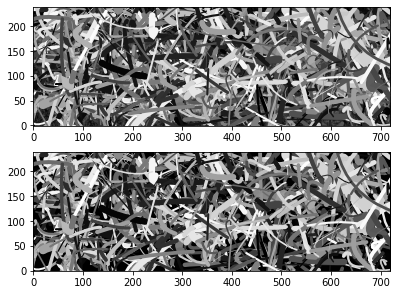

In [68]:
# Initialise clew of 40 and draw

GENERATIONS = 15
POPULATION = 1000
PERCENT = 10

#clew = initialise_clew(40, image.shape, (40, 30, 1))
clew = initialise_clew(POPULATION, image.shape, (40, 30, 1))
drawing = Drawing(image)
drawing.add_worms(clew)
drawing.show()

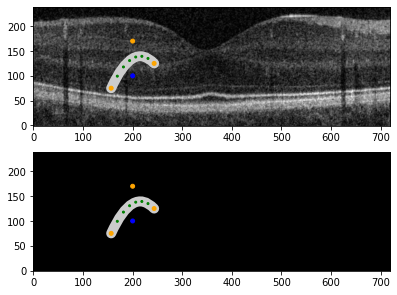

In [69]:
# Draw a single worm along with control points and some sample points

worm = Camo_Worm(200, 100, 50, np.pi/6, 70, np.pi/3, 10, 0.8)
drawing = Drawing(image)
drawing.add_worms(worm)
drawing.add_dots(worm.intermediate_points(8), radius=2, color='green')
drawing.add_dots(worm.control_points(),color='orange')
drawing.add_dots((200,100), color='blue')



drawing.show(save='bezier.png')

In [70]:
def average_distance(worm, clew):
    dists = []
    """ for i in range(len(clew)):
        if i is not worm_idx:
            euclid_dist = np.linalg.norm(np.array((worm.x, worm.y))-np.array((clew[i].x, clew[i].y)))
            # print(f"Worm centre ({worm.x}, {worm.y})")
            # print(f"Other worm centre ({clew[i].x}, {clew[i].y})")
            # print(f"Dist: {euclid_dist}")
            dists.append(euclid_dist)
    """

    for i in range(len(clew)):
        # print("Distance: ({x1},{y1}) to ({x2},{y2})".format(x1=worm.x, y1=worm.y, x2=clew[i].x, y2=clew[i].y))
        euclid_dist = np.linalg.norm(np.array((worm.x, worm.y))-np.array((clew[i].x, clew[i].y)))
        # print(f"Worm centre ({worm.x}, {worm.y})")
        # print(f"Other worm centre ({clew[i].x}, {clew[i].y})")
        # print(f"Dist: {euclid_dist}")
        #print("euclid_dist:{}".format(euclid_dist))
        if(euclid_dist != 0):
            dists.append(euclid_dist)

        # don't bother checking if it's the same worm. It will just be a distance of 0.

    if(dists):  # not empty
        avg_dist = np.mean(dists)
    else:
        avg_dist = 0
        print("Nothing in list. Len={}".format(len(clew)))

    return avg_dist


def average_colour_diff(worm, image):

    # Range of 10 t values to gather points for
    t_range = [t / 10 for t in range(0, 11, 1)] # [0.1, 0.2, 0.3... 0.9, 1.0]

    #print(t_range)

    total_colour_diff = 0
    count = 0

    for t in t_range:
        image_colour = worm.colour_at_t( t, image )
        if(image_colour > -1): # If it returns -1, it means the point is outside the image
            count = count + 1
            total_colour_diff = total_colour_diff + abs(worm.colour - image_colour)
        else:
            # assume maximum difference as penalty
            count = count + 1
            total_colour_diff = total_colour_diff + 255

    #print(total_colour_diff)
    if(count > 0):
          colour_diff_ave = total_colour_diff/count # To get average, divide by 10 samples
    else: colour_diff_ave=0
    return colour_diff_ave

def average_contrast(worm, image):
    # Gather points at boundary of worm to test
    total_contrast = 0
    count = 0

    for edge_point in worm.edge_points(5):
        # Get image colour at boundary
        x = round(edge_point[0])    # Only whole indexes are allowed
        y = round(edge_point[1])    # The maths that finds edge points can get decimals
        image_colour = worm.colour_at_xy( x, y, image)
        #print("Colour difference at (x,y)=({},{})\nWorm Colour = {}\nImage Colour ={}".format(x,y, worm.colour, image_colour))
        # Calculate contrast by comparing worm body colour with edge colour
        # Assume worm is similar colour to background because of score function
        total_contrast = total_contrast + abs(image_colour - worm.colour)
        count = count + 1

    if(count > 0):
          contrast_ave = total_contrast/count # To get average, divide by 10 samples
    else: contrast_ave=0
    return contrast_ave

# a sorting function
def eval_worm(worm, clew_var=clew, image_var=image, size_weight=100, dist_weight=1300, colour_weight=1500, contrast_weight=150, print_results=False):
    # NOTE: image and clew is hardcoded, as variables can't be passed through sort(key=...)

    score = 0

    #contrast_weight=80
    
    # ------------ Internal Knowledge ------------
    
    # --- Size ---
    # Big Worms to counteract 1 pixel worms being highest score
    size = worm.approx_length() / image_var.shape[1] # size as a percentage of image width
    size_comp = size_weight*size
    
    
    # ------------ Group Knowledge ------------
    
    # --- Average Distance ---
    """
    dist_weight=0.2
    average_dist = average_distance(worm, clew_var)
    dist_comp = dist_weight * average_dist
    """    
    average_dist = average_distance(worm, clew_var)
    # option1
    # want worms spread out (add small constant to prevent divide by 0)
    # take min with 1 to keep on scale 0 to 1
    inversed = min(1/(average_dist+0.00001), 1)
    # define as 0 for some ideal distance apart (should define it better than max(image.shape))
    """ if average_dist > max(image.shape):
        inversed = 0
    # define as 1 for too far apart
    if average_dist > max(image.shape)*1.05:
        inversed = 1 """
    dist_comp = dist_weight * inversed
    


    
    # ------------ Environmental Knowledge ------------

    # --- Colour Difference ---
    # Compare to colour (inverse)
    colour_diff = average_colour_diff(worm, image_var)
    colour_comp = colour_weight* -colour_diff


    # --- Contrast ---
    # Find hard edges around worm
    contrast = average_contrast(worm, image)
    contrast_comp = contrast_weight*contrast


    # ------------ Final Calibration ------------

    # Sort doesn't work with decimals
    score = round( (size_comp + dist_comp + colour_comp + contrast_comp)*1000 )

    if(score < 0):
        score = 0 # No negatives allowed for sorting. Assume anything with a score of 0 will get discarded.

    if(print_results):
        print( "    Score: (sz={print_size}) + (dist={print_dist}) + (col={print_colour}) + (con={print_contrast}) = {print_score}".format(
            print_size=size_comp,
            print_dist = dist_comp,
            print_colour=colour_comp,
            print_contrast = contrast_comp,
            print_score = score) )
    
    return score

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
[157  75]
[165  93]
[174 107]
[183 119]
[191 129]
[200 135]
[209 139]
[217 139]
[226 137]
[235 133]
[243 125]


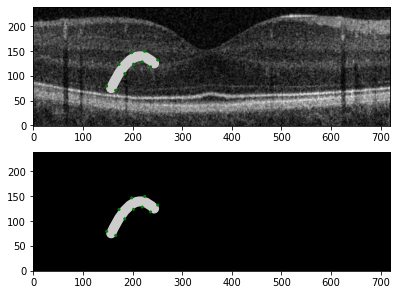

(240, 720)


In [71]:
# Draw a single worm along with control points and some sample points

worm = Camo_Worm(200, 100, 50, np.pi/6, 70, np.pi/3, 10, 0.8)

t_range = [t / 10 for t in range(0, 11, 1)] # [0.1, 0.2, 0.3... 0.9]
print(t_range)

coords = []
for t in t_range:
    print(worm.coords_at_t(t))
    coords.append(  worm.coords_at_t(t) )

#print(coords)

drawing = Drawing(image)
drawing.add_worms(worm)
#drawing.add_dots(coords, radius=2, color='green')
drawing.add_dots(worm.edge_points(5), radius=2, color='green')

drawing.show(save='bezier.png')


print(image.shape)
# reversed as [y, x]

--------Generation 0------------
Test first 5 vals
    Score: (sz=11.5043572773344) + (dist=5.993955608110453) + (col=-183.41058259510643) + (con=15.961379115125617) = 0
    Score: (sz=9.111544634482918) + (dist=4.447347152849474) + (col=-756.6721981744887) + (con=70.06294174258257) = 0
    Score: (sz=10.340709028363461) + (dist=6.256114109523392) + (col=-315.23450537427476) + (con=24.748172194647857) = 0
    Score: (sz=8.216169473724037) + (dist=6.393438296830607) + (col=-558.1632139949088) + (con=51.912578083982865) = 0
    Score: (sz=14.59880902384938) + (dist=5.482758633953225) + (col=-95.79296669171787) + (con=13.763000725051048) = 0
Best Worm:
    Score: (sz=11.5043572773344) + (dist=5.993955608110453) + (col=-183.41058259510643) + (con=15.961379115125617) = 0


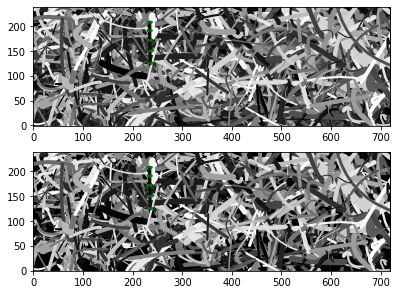

Average Score: 0.0
--------Generation 1------------
Test first 5 vals
    Score: (sz=3.836953072225461) + (dist=3.648466590731648) + (col=-73.1861346693449) + (con=132.47855443215298) = 66778
    Score: (sz=6.160220884879459) + (dist=4.913928824144818) + (col=-84.70187792707151) + (con=78.09431341899021) = 4467
    Score: (sz=11.5043572773344) + (dist=5.993955608110453) + (col=-183.41058259510643) + (con=15.961379115125617) = 0
    Score: (sz=9.111544634482918) + (dist=4.447347152849474) + (col=-756.6721981744887) + (con=70.06294174258257) = 0
    Score: (sz=10.340709028363461) + (dist=6.256114109523392) + (col=-315.23450537427476) + (con=24.748172194647857) = 0
Best Worm:
    Score: (sz=3.836953072225461) + (dist=3.648466590731648) + (col=-73.1861346693449) + (con=132.47855443215298) = 66778


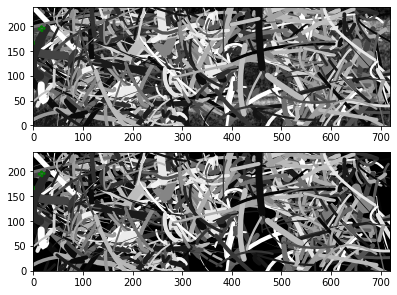

Average Score: 71.245
--------Generation 2------------
Test first 5 vals
    Score: (sz=3.836953072225461) + (dist=3.648466590731648) + (col=-73.1861346693449) + (con=132.47855443215298) = 66778
    Score: (sz=6.164563651262427) + (dist=4.913928824144818) + (col=-60.05219643005701) + (con=86.90475638786192) = 37931
    Score: (sz=6.160220884879459) + (dist=4.913928824144818) + (col=-84.70187792707151) + (con=78.09431341899021) = 4467
    Score: (sz=11.5043572773344) + (dist=5.993955608110453) + (col=-183.41058259510643) + (con=15.961379115125617) = 0
    Score: (sz=9.111544634482918) + (dist=4.447347152849474) + (col=-756.6721981744887) + (con=70.06294174258257) = 0
Best Worm:
    Score: (sz=3.836953072225461) + (dist=3.648466590731648) + (col=-73.1861346693449) + (con=132.47855443215298) = 66778


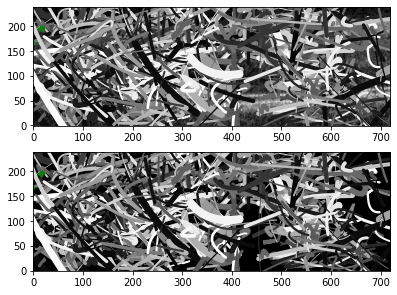

Average Score: 109.176
--------Generation 3------------
Test first 5 vals
    Score: (sz=3.836953072225461) + (dist=3.648466590731648) + (col=-73.1861346693449) + (con=132.47855443215298) = 66778
    Score: (sz=6.164563651262427) + (dist=4.913928824144818) + (col=-60.05219643005701) + (con=86.90475638786192) = 37931
    Score: (sz=4.7288962084169555) + (dist=6.619879489955822) + (col=-87.9158287796367) + (con=95.97430374526289) = 19407
    Score: (sz=6.160220884879459) + (dist=4.913928824144818) + (col=-84.70187792707151) + (con=78.09431341899021) = 4467
    Score: (sz=11.5043572773344) + (dist=5.993955608110453) + (col=-183.41058259510643) + (con=15.961379115125617) = 0
Best Worm:
    Score: (sz=3.836953072225461) + (dist=3.648466590731648) + (col=-73.1861346693449) + (con=132.47855443215298) = 66778


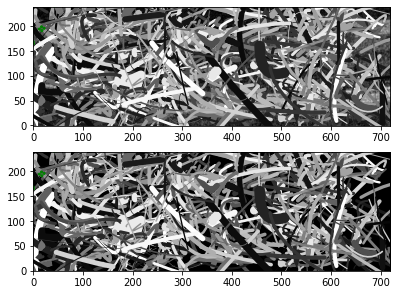

Average Score: 128.583
--------Generation 4------------
Test first 5 vals
    Score: (sz=3.836953072225461) + (dist=3.648466590731648) + (col=-73.1861346693449) + (con=132.47855443215298) = 66778
    Score: (sz=6.164563651262427) + (dist=4.913928824144818) + (col=-60.05219643005701) + (con=86.90475638786192) = 37931
    Score: (sz=6.164563651262427) + (dist=4.913928824144818) + (col=-60.05219643005701) + (con=86.90475638786192) = 37931
    Score: (sz=8.597725390684129) + (dist=6.619879489955822) + (col=-78.8249196887276) + (con=95.85665668643934) = 32249
    Score: (sz=5.3434979548613395) + (dist=6.619879489955822) + (col=-68.0326207683094) + (con=84.59979089342424) = 28531
Best Worm:
    Score: (sz=3.836953072225461) + (dist=3.648466590731648) + (col=-73.1861346693449) + (con=132.47855443215298) = 66778


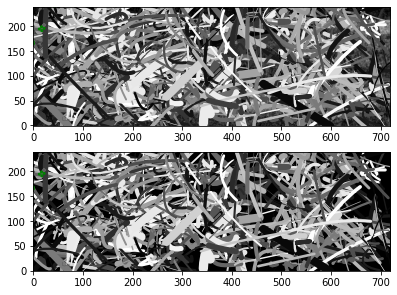

Average Score: 244.765
--------Generation 5------------
Test first 5 vals
    Score: (sz=3.836953072225461) + (dist=3.648466590731648) + (col=-73.1861346693449) + (con=132.47855443215298) = 66778
    Score: (sz=5.3434979548613395) + (dist=6.619879489955822) + (col=-68.0326207683094) + (con=100.36449677577718) = 44295
    Score: (sz=4.7288962084197) + (dist=6.659493142602501) + (col=-76.79867540824515) + (con=107.44992101676034) = 42040
    Score: (sz=10.354103088160846) + (dist=4.43156337887512) + (col=-117.66554831661072) + (con=143.11214918924892) = 40232
    Score: (sz=6.164563651262427) + (dist=4.913928824144818) + (col=-60.05219643005701) + (con=86.90475638786192) = 37931
Best Worm:
    Score: (sz=3.836953072225461) + (dist=3.648466590731648) + (col=-73.1861346693449) + (con=132.47855443215298) = 66778


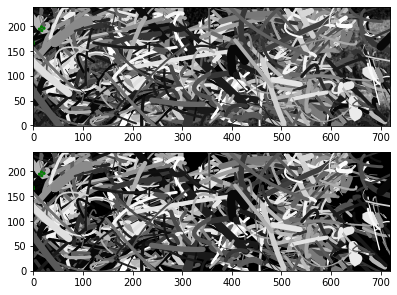

Average Score: 388.951
--------Generation 6------------
Test first 5 vals
    Score: (sz=5.3434979548612835) + (dist=6.659493142602501) + (col=-41.72436130937246) + (con=103.4262092050156) = 73705
    Score: (sz=3.836953072225461) + (dist=3.648466590731648) + (col=-73.1861346693449) + (con=132.47855443215298) = 66778
    Score: (sz=3.836953072225461) + (dist=3.648466590731648) + (col=-73.1861346693449) + (con=132.47855443215298) = 66778
    Score: (sz=8.390551881468346) + (dist=4.9815952435826665) + (col=-58.804741031279455) + (con=109.52527832099915) = 64093
    Score: (sz=5.341912631669343) + (dist=6.619879489955822) + (col=-50.867795851675154) + (con=101.12920265813014) = 62223
Best Worm:
    Score: (sz=5.3434979548612835) + (dist=6.659493142602501) + (col=-41.72436130937246) + (con=103.4262092050156) = 73705


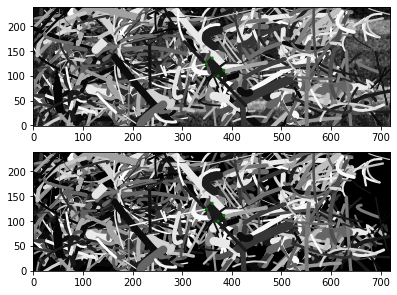

Average Score: 886.482
--------Generation 7------------
Test first 5 vals
    Score: (sz=5.3434979548612835) + (dist=6.659493142602501) + (col=-41.72436130937246) + (con=103.4262092050156) = 73705
    Score: (sz=3.836953072225461) + (dist=3.648466590731648) + (col=-73.1861346693449) + (con=132.47855443215298) = 66778
    Score: (sz=3.836953072225461) + (dist=3.648466590731648) + (col=-73.1861346693449) + (con=132.47855443215298) = 66778
    Score: (sz=8.390551881468346) + (dist=4.9815952435826665) + (col=-58.804741031279455) + (con=109.52527832099915) = 64093
    Score: (sz=6.542935689757774) + (dist=4.411078712470336) + (col=-58.95993047968981) + (con=110.9387905896377) = 62933
Best Worm:
    Score: (sz=5.3434979548612835) + (dist=6.659493142602501) + (col=-41.72436130937246) + (con=103.4262092050156) = 73705


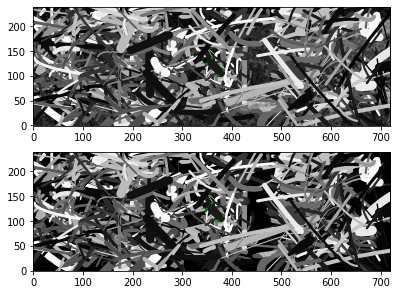

Average Score: 1819.947
--------Generation 8------------
Test first 5 vals
    Score: (sz=1.0505135250727933) + (dist=5.39773559948659) + (col=-27.943887698941143) + (con=110.55584117822359) = 89060
    Score: (sz=2.978825482020941) + (dist=5.008606260831506) + (col=-32.4947647011015) + (con=113.202900001753) = 88696
    Score: (sz=8.39143378030988) + (dist=6.4862317311073845) + (col=-40.69807637140227) + (con=107.10524672770327) = 81285
    Score: (sz=1.4071843863266569) + (dist=3.9711436479455484) + (col=-63.287003430535236) + (con=132.05976680577183) = 74151
    Score: (sz=5.3434979548612835) + (dist=6.659493142602501) + (col=-41.72436130937246) + (con=103.4262092050156) = 73705
Best Worm:
    Score: (sz=1.0505135250727933) + (dist=5.39773559948659) + (col=-27.943887698941143) + (con=110.55584117822359) = 89060


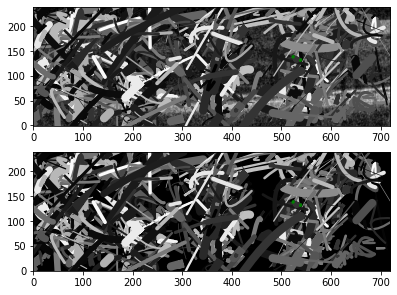

Average Score: 4727.668
--------Generation 9------------
Test first 5 vals
    Score: (sz=6.1593666251508035) + (dist=3.610075695804587) + (col=-36.832738907683144) + (con=120.29989544671213) = 93237
    Score: (sz=2.976299304802875) + (dist=4.971207218728951) + (col=-20.33398697782166) + (con=102.7675947821796) = 90381
    Score: (sz=4.791232591467295) + (dist=6.101300119065932) + (col=-14.838194877480985) + (con=93.60911383634739) = 89663
    Score: (sz=1.0505135250727933) + (dist=5.39773559948659) + (col=-27.943887698941143) + (con=110.55584117822359) = 89060
    Score: (sz=2.978825482020941) + (dist=5.008606260831506) + (col=-32.4947647011015) + (con=113.202900001753) = 88696
Best Worm:
    Score: (sz=6.1593666251508035) + (dist=3.610075695804587) + (col=-36.832738907683144) + (con=120.29989544671213) = 93237


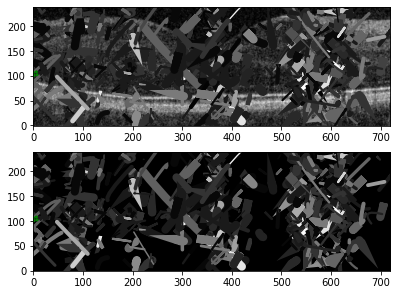

Average Score: 16051.985
--------Generation 10------------
Test first 5 vals
    Score: (sz=5.3419126316694525) + (dist=4.0964583678913) + (col=-41.021198311029615) + (con=131.22656288293828) = 99644
    Score: (sz=8.391433780309859) + (dist=5.297411745630381) + (col=-26.109266653723495) + (con=107.81939596805798) = 95399
    Score: (sz=6.1593666251508035) + (dist=3.610075695804587) + (col=-36.832738907683144) + (con=120.29989544671213) = 93237
    Score: (sz=6.1593666251508035) + (dist=3.610075695804587) + (col=-36.832738907683144) + (con=120.29989544671213) = 93237
    Score: (sz=1.659147870415083) + (dist=4.092211010455924) + (col=-7.727901989991934) + (con=94.49402535519334) = 92517
Best Worm:
    Score: (sz=5.3419126316694525) + (dist=4.0964583678913) + (col=-41.021198311029615) + (con=131.22656288293828) = 99644


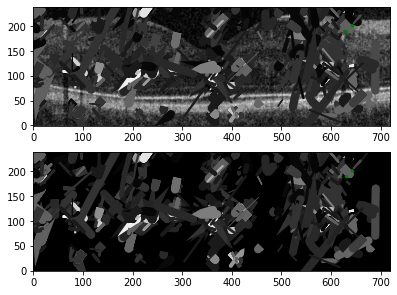

Average Score: 24867.169
--------Generation 11------------
Test first 5 vals
    Score: (sz=5.3419126316694525) + (dist=4.0964583678913) + (col=-41.021198311029615) + (con=131.22656288293828) = 99644
    Score: (sz=5.3419126316694525) + (dist=4.0964583678913) + (col=-41.021198311029615) + (con=131.22656288293828) = 99644
    Score: (sz=8.390525169415188) + (dist=4.920240828490644) + (col=-26.601566846513403) + (con=109.52821882423062) = 96237
    Score: (sz=8.391433780309859) + (dist=5.297411745630381) + (col=-26.109266653723495) + (con=107.81939596805798) = 95399
    Score: (sz=0.5717926422367167) + (dist=6.619879489955822) + (col=-14.294057682464407) + (con=102.1880261875419) = 95086
Best Worm:
    Score: (sz=5.3419126316694525) + (dist=4.0964583678913) + (col=-41.021198311029615) + (con=131.22656288293828) = 99644


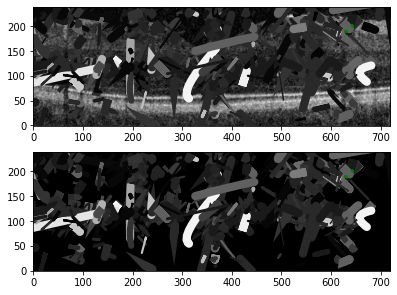

Average Score: 26140.345
--------Generation 12------------
Test first 5 vals
    Score: (sz=5.3419126316694525) + (dist=4.0964583678913) + (col=-41.021198311029615) + (con=131.22656288293828) = 99644
    Score: (sz=5.3419126316694525) + (dist=4.0964583678913) + (col=-41.021198311029615) + (con=131.22656288293828) = 99644
    Score: (sz=0.42829553749426247) + (dist=4.0964583678913) + (col=-33.99690668183141) + (con=126.61289892254416) = 97141
    Score: (sz=8.390525169415188) + (dist=4.920240828490644) + (col=-26.601566846513403) + (con=109.52821882423062) = 96237
    Score: (sz=8.390525169415188) + (dist=4.920240828490644) + (col=-26.601566846513403) + (con=109.52821882423062) = 96237
Best Worm:
    Score: (sz=5.3419126316694525) + (dist=4.0964583678913) + (col=-41.021198311029615) + (con=131.22656288293828) = 99644


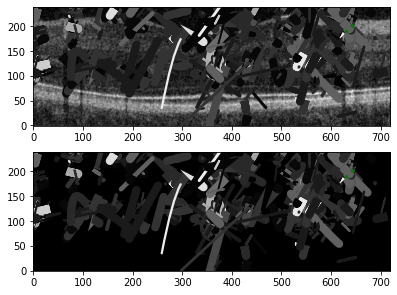

Average Score: 29801.978
--------Generation 13------------
Test first 5 vals
    Score: (sz=1.0503584896669074) + (dist=3.6019381185497203) + (col=-40.58534608849077) + (con=141.15580336970152) = 105223
    Score: (sz=0.42829553750232874) + (dist=4.0964583678913) + (col=-26.58269563723283) + (con=125.00796619685887) = 102950
    Score: (sz=2.8240483977250506) + (dist=5.592830019786395) + (col=-48.03440034356307) + (con=140.15993681340828) = 100542
    Score: (sz=5.3419126316694525) + (dist=4.0964583678913) + (col=-41.021198311029615) + (con=131.22656288293828) = 99644
    Score: (sz=5.3419126316694525) + (dist=4.0964583678913) + (col=-41.021198311029615) + (con=131.22656288293828) = 99644
Best Worm:
    Score: (sz=1.0503584896669074) + (dist=3.6019381185497203) + (col=-40.58534608849077) + (con=141.15580336970152) = 105223


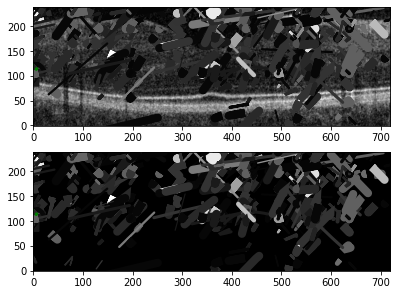

Average Score: 31865.274
--------Generation 14------------
Test first 5 vals
    Score: (sz=1.0503584896669074) + (dist=3.6019381185497203) + (col=-40.58534608849077) + (con=141.15580336970152) = 105223
    Score: (sz=0.42829553750232874) + (dist=4.0964583678913) + (col=-26.58269563723283) + (con=125.00796619685887) = 102950
    Score: (sz=0.42829553750232874) + (dist=4.0964583678913) + (col=-26.58269563723283) + (con=125.00796619685887) = 102950
    Score: (sz=8.39052516941492) + (dist=4.036369396575782) + (col=-44.99568351247329) + (con=134.75597464764417) = 102187
    Score: (sz=2.8240483977250506) + (dist=5.592830019786395) + (col=-48.03440034356307) + (con=140.15993681340828) = 100542
Best Worm:
    Score: (sz=1.0503584896669074) + (dist=3.6019381185497203) + (col=-40.58534608849077) + (con=141.15580336970152) = 105223


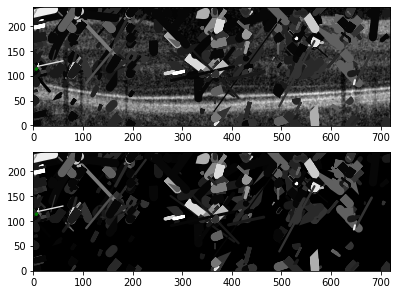

Average Score: 33578.042


In [72]:
""" class Clew:
    def __init__(self, clew, image):
        self.clew = clew
        self.image = image
    def sort(self):
        self.clew """



# hardcode 10 generations
for gen in range(GENERATIONS):

    print("--------Generation {}------------".format(gen))
    
    # sort in order with a scoring function

    clew = sorted(clew, key=eval_worm, reverse=True) # this will only work because eval_worm has one argument
    # clew.sort(key= eval_worm) # this will only work because eval_worm has one argument
    # clew.reverse() # need to reverse because higher numbers get put at bottom

    # Test of first 5 values
    print("Test first 5 vals")
    for i in range(5):
        current_worm = clew[i]
        score = eval_worm(current_worm, print_results=True)

    drawing = Drawing(image)
    drawing.add_worms(clew)

    best_worm = clew[0]
    print("Best Worm:")
    eval_worm(best_worm, print_results=True)
    #print("    Best environment worm point: x %2d, y %2d" %(best_worm.x, best_worm.y))
    #print("    Length: %.2f, width %.2f and colour: %.2f" % (best_worm.approx_length(), best_worm.width, best_worm.colour* 255 ))
    drawing.add_worms(best_worm) # put it on top
    #drawing.add_dots(best_worm.intermediate_points(5), 2, color="orange")
    drawing.add_dots(best_worm.edge_points(5), 2, color="green")

    drawing.show()
    
    n = 0
    total = 0
    for worm in clew:
        #score = eval_worm(worm, print_results=True)
        score = eval_worm(worm)
        #print(score)
        n += 1
        total += score
    ave=total/n
    print("Average Score: {}".format(ave))
    
    
    # get top 10% to start next generation
    ten_perc = round( (PERCENT/100) * POPULATION )

    new_clew = []
    for i in range(ten_perc):
        new_clew.append( clew[i] )
    
    # use top 10% to generate the rest of the population
    # ------------- TO FIX: CURRENTLY BOTH PARENTS CAN BE SAME ------------------
    
    for i in range( POPULATION - ten_perc ): # get remaining 90% of pop
    
        rand1 = rng.integers(0, ten_perc) # pick one of the top 10%
        parent1 = clew[rand1]

        rand2 = rng.integers(0, ten_perc)
        parent2 = clew[rand2]

        child = parent1.mate(parent2)
        new_clew.append(child)
    
    # replace the previous generation
    clew = new_clew
    
    #print(len(clew))
    
    

&copy; Cara MacNish, UWA, 2024